In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

1. Обучите любую модель классификации на датасете IRIS до применения PCA и после него. Сравните качество классификации по отложенной выборке.

In [2]:
random.seed(42)
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels)) 
    return bootstrap


def get_subsample(len_sample):
    sample_indexes = [i for i in range(len_sample)]
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
    return subsample


class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch


class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()


    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1    
        prediction = max(classes, key=classes.get)
        return prediction 


def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity


def quality(left_labels, right_labels, current_gini):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)  
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]  
    return true_data, false_data, true_labels, false_labels


def find_best_split(data, labels):
    min_leaf = 5
    current_gini = gini(labels)
    best_quality = 0
    best_t = None
    best_index = None
    n_features = data.shape[1]
    subsample = get_subsample(n_features)
    for index in subsample:
        t_values = [row[index] for row in data]
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            current_quality = quality(true_labels, false_labels, current_gini)
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
    return best_quality, best_t, best_index


def build_tree(data, labels):
    quality, t, index = find_best_split(data, labels)
    if quality == 0:
        return Leaf(data, labels)
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    return Node(index, t, true_branch, false_branch)


def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
    return forest


def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)


def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes


def tree_vote(forest, data):
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    predictions_per_object = list(zip(*predictions))
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))  
    return voted_predictions

In [5]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [6]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [7]:
def metrics_random_forest(train_data, train_labels, n_trees):
    my_forest = random_forest(train_data, train_labels, n_trees)
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)
    test_accuracy = accuracy_metric(test_labels, test_answers)
    return test_accuracy

In [10]:
print(metrics_random_forest(train_data, train_labels, 2))

95.55555555555556


In [13]:
def pca(X, n_components):
    X_ = X.astype(float)
    rows, cols = X_.shape
    means = X_.mean(0)
    for i in range(rows):
        for j in range(cols):
            X_[i, j] -= means[j]
    std = np.std(X_, axis=0)
    for i in range(cols):
        for j in range(rows):
            X_[j][i] /= std[i]
    covariance_matrix = X_.T.dot(X_)
    eig_values, eig_vectors = np.linalg.eig(covariance_matrix)
    eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    eig_sum = sum(eig_values)
    var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    W = np.hstack((eig_pairs[i][1].reshape(4,1) for i in range(n_components)))
    return X_.dot(W)

In [14]:
X_reduced = pca(X, 2)

/tmp/ipykernel_167620/1814338293.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  W = np.hstack((eig_pairs[i][1].reshape(4,1) for i in range(n_components)))


In [15]:
train_data, test_data, train_labels, test_labels = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

In [16]:
print(metrics_random_forest(train_data, train_labels, 2))

80.0


2. Напишите свою реализацию метода главных компонент посредством сингулярного разложения с использованием функции numpy.linalg.svd().

In [3]:
def pca_svd(X, n_components):
    X = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X.T)
    U, S, V = np.linalg.svd(cov_matrix)
    idx = np.argsort(-S)
    U = U[:, idx]
    S = S[idx]
    U_reduced = U[:, :n_components]
    X_reduced = np.dot(X, U_reduced)
    return X_reduced

In [4]:
X_reduced = pca_svd(X, 2)

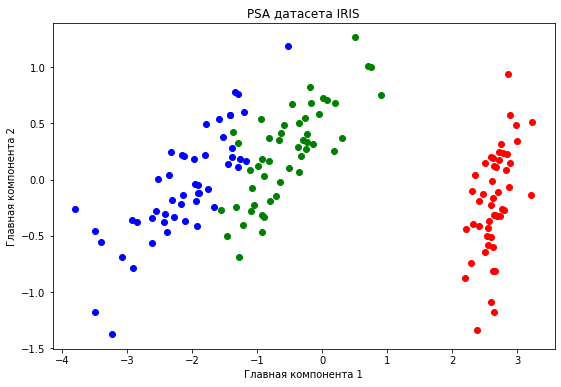

In [6]:
y = iris.target
fig, ax = plt.subplots(1, figsize=(9, 6))
ax.set_title('PSA датасета IRIS')
ax.set_xlabel('Главная компонента 1')
ax.set_ylabel('Главная компонента 2')
for i, c in enumerate('rgb'):
    ax.scatter(X_reduced[y==i, 0], X_reduced[y==i, 1], c=c)
plt.show()